In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/Estudo%20COVID%20-%20Insights%20e%20Previs%C3%B5es/dados/Silver/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20M%C3%A9xico.csv'

serie_mex = pd.read_csv(url)
serie_mex.drop(['Unnamed: 0','Confirmed','Recovered','Ano'],axis=1,
               inplace=True)
serie_mex.head()

,Date,Deaths
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [3]:
# Selecionando apenas os primeiros meses do dataset
serie_arg = serie_mex[0:161]

In [4]:
serie_mex['Date'] = pd.to_datetime(serie_mex['Date'],format='%Y-%m-%d')
serie_mex.set_index('Date',inplace=True)
serie_mex.head()

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


In [5]:
treino = serie_mex[0:131]
teste = serie_mex[131:161]

In [6]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)
P = range(0, 5, 1)
D = 1
Q = range(0, 5, 1)
s = 2
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

625


In [8]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df.head()

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(4, 3, 0, 1)",1311.171922
1,"(2, 3, 2, 2)",1313.425749
2,"(3, 2, 2, 1)",1314.853559
3,"(2, 3, 4, 0)",1315.481562
4,"(2, 3, 2, 3)",1315.898739


In [17]:
best_model = SARIMAX(treino['Deaths'], order=(2, 1, 3), seasonal_order=(2, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 Deaths   No. Observations:                  131
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2], 4)   Log Likelihood                -646.713
Date:                                Tue, 17 Jan 2023   AIC                           1313.426
Time:                                        00:32:06   BIC                           1341.789
Sample:                                    01-22-2020   HQIC                          1324.949
                                         - 05-31-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2684      0.035     36.547      0.000       1.200       1.336
ar.

In [18]:
fc = best_model.forecast(30, alpha=0.05)

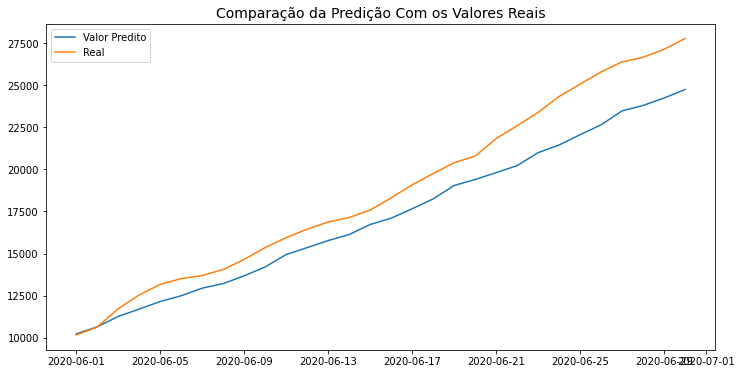

In [19]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [20]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.07557831111482254
MAE: 1551.9085834120608
RMSE: 1806.9435079050006
